# Capstone Project: Image Caption Generator reader with language translation

The aim of this project was to develop an intelligent image captioning system capable of generating meaningful and grammatically correct textual descriptions for a given image. This system integrates computer vision and natural language processing techniques to bridge the gap between visual understanding and language generation. To achieve this within limited computational resources and time, a basic encoder-decoder framework was implemented using a pretrained InceptionV3 model as the encoder for feature extraction and an LSTM-based decoder to generate captions. The system was further enhanced by translating the generated captions into other languages using Google Translate API, followed by converting them into speech using gTTS, enabling multimodal output in both text and audio formats.

The methodology involved extracting image features using InceptionV3, followed by sequence generation using greedy decoding to form captions. BLEU score evaluation was employed to assess the quality of the generated captions. The model demonstrated satisfactory performance in generating coherent and relevant descriptions for various test images. This foundational implementation lays the groundwork for future enhancement, where advanced techniques such as ResNet-101 with CBAM for feature refinement, Faster R-CNN for object detection, and multimodal attention mechanisms in the decoder will be integrated to improve caption quality, accuracy, and context-awareness.

# Importing the Necessary libraries!..........................................................

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

# Loading the Image descriptions!...................................................................

In [4]:
images_directory = "D:\DL_capstoneproject\Images"
captions_path = "D:\DL_capstoneproject\captions.txt"
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

# Cleaning the text (removing characters from the image captions))!........................

In [7]:
import re

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

# Preprocessing the captions ..................................................................

In [10]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

# Finding the maximum length of the caption for a given image.........................

In [13]:
cleaned_captions
l = []
for i in cleaned_captions:
    l.append(len(i.split(' ')))

max(l)

33

<Axes: ylabel='Count'>

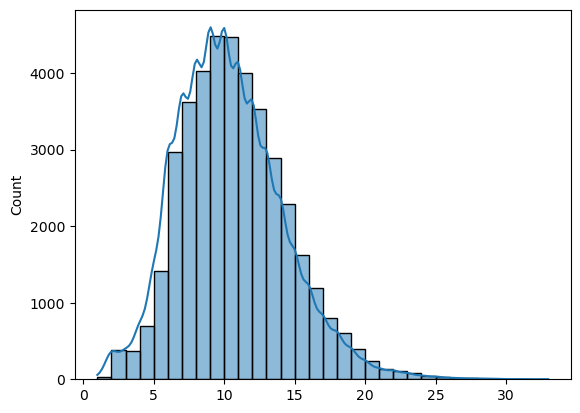

In [15]:
import seaborn as sns
sns.histplot(x = l,kde=True, binwidth=1)

# Tokenizing the vocabulary to get the total vocabulary..............................................

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_captions)

In [20]:
vocab_size = tokenizer.word_index
len(vocab_size)

8585

In [22]:
all_image_ids = os.listdir(images_directory)

Image Id's

In [25]:
all_image_ids

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg',
 '1007320043_627395c3d8.jpg',
 '1009434119_febe49276a.jpg',
 '1012212859_01547e3f17.jpg',
 '1015118661_980735411b.jpg',
 '1015584366_dfcec3c85a.jpg',
 '101654506_8eb26cfb60.jpg',
 '101669240_b2d3e7f17b.jpg',
 '1016887272_03199f49c4.jpg',
 '1019077836_6fc9b15408.jpg',
 '1019604187_d087bf9a5f.jpg',
 '1020651753_06077ec457.jpg',
 '1022454332_6af2c1449a.jpg',
 '1022454428_b6b660a67b.jpg',
 '1022975728_75515238d8.jpg',
 '102351840_323e3de834.jpg',
 '1024138940_f1fefbdce1.jpg',
 '102455176_5f8ead62d5.jpg',
 '1026685415_0431cbf574.jpg',
 '1028205764_7e8df9a2ea.jpg',
 '1030985833_b0902ea560.jpg',
 '103106960_e8a41d64f8.jpg',
 '103195344_5d2dc613a3.jpg',
 '103205630_682ca7285b.jpg',
 '1032122270_ea6f0beedb.jpg',
 '1032460886_4a598ed535.jpg',
 '1034276567_49bb87c51c.jpg',
 '104136873_5b5d41be75.jpg',
 '1042020065_fb3d3ba5ba.jpg',
 '1042590306_95dea

In [27]:
captions_IDs[0].split('\t')

['1000268201_693b08cb0e.jpg',
 'start a child in a pink dress is climbing up a set of stairs in an entry way end\n']

# Splitting the data into train, validation and test sets....................................

In [30]:
all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1022454428_b6b660a67b.jpg\tstart a couple and an infant end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

In [32]:
len(train_captions)

34385

# Extracting feature vector from the image ....................................................

In [35]:
from PIL import Image
image_path = r"D:\DL_capstoneproject\Images\10815824_2997e03d76.jpg"

img = Image.open(image_path)

img.show()

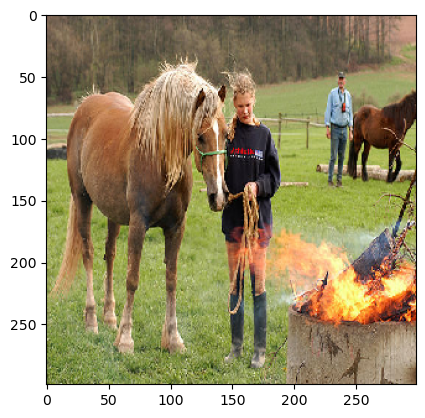

In [37]:
img = load_img(image_path, target_size=(299,299))
plt.imshow(img)

In [39]:
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

In [41]:
img

array([[[[120.,  94.,  79.],
         [123.,  97.,  82.],
         [129., 103.,  88.],
         ...,
         [204., 158., 135.],
         [205., 157., 137.],
         [202., 154., 134.]],

        [[128., 102.,  87.],
         [123.,  97.,  82.],
         [131., 105.,  90.],
         ...,
         [205., 159., 136.],
         [206., 158., 138.],
         [204., 156., 136.]],

        [[137., 111.,  96.],
         [123.,  97.,  82.],
         [133., 107.,  92.],
         ...,
         [206., 160., 137.],
         [206., 159., 139.],
         [205., 158., 138.]],

        ...,

        [[174., 186., 100.],
         [114., 136.,  63.],
         [132., 141.,  88.],
         ...,
         [114.,  85.,  55.],
         [128.,  97.,  68.],
         [113.,  81.,  56.]],

        [[151., 162.,  66.],
         [ 80., 101.,  24.],
         [129., 134.,  93.],
         ...,
         [134., 107.,  77.],
         [132., 103.,  73.],
         [122.,  88.,  61.]],

        [[145., 154.,  73.],
       

In [43]:
img = tf.keras.applications.inception_v3.preprocess_input(img)
img

array([[[[-0.05882353, -0.26274508, -0.38039213],
         [-0.03529412, -0.23921567, -0.35686272],
         [ 0.01176476, -0.19215685, -0.3098039 ],
         ...,
         [ 0.6       ,  0.23921573,  0.05882359],
         [ 0.60784316,  0.2313726 ,  0.07450986],
         [ 0.58431375,  0.20784318,  0.05098045]],

        [[ 0.00392163, -0.19999999, -0.31764704],
         [-0.03529412, -0.23921567, -0.35686272],
         [ 0.02745104, -0.17647058, -0.29411763],
         ...,
         [ 0.60784316,  0.24705887,  0.06666672],
         [ 0.6156863 ,  0.23921573,  0.082353  ],
         [ 0.6       ,  0.22352946,  0.06666672]],

        [[ 0.07450986, -0.12941176, -0.24705881],
         [-0.03529412, -0.23921567, -0.35686272],
         [ 0.04313731, -0.1607843 , -0.27843136],
         ...,
         [ 0.6156863 ,  0.254902  ,  0.07450986],
         [ 0.6156863 ,  0.24705887,  0.09019613],
         [ 0.60784316,  0.23921573,  0.082353  ]],

        ...,

        [[ 0.36470592,  0.45882356, -0

# Extracting features vector from all the images ...........................................

In [46]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

In [48]:
extimg = extract_image_features(inception_v3_model,image_path)

In [49]:
extimg.flatten()

array([0.34266344, 0.16739711, 0.09924426, ..., 0.2121681 , 0.46709558,
       0.2527647 ], dtype=float32)

# Extracting images features for training, testing and validation dataset ...................

In [59]:
from tqdm import tqdm

train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs

# pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in tqdm(all_image_ids):
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        # pbar.update(1)

    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        # pbar.update(1)

    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        # pbar.update(1)

    else:
        print('Unknown image ID !')

# pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [17:20<00:00,  7.77it/s]


In [81]:
train_image_features['1000268201_693b08cb0e.jpg']

array([0.12277614, 0.3329489 , 0.7527173 , ..., 0.21939704, 0.3021639 ,
       0.40283206], dtype=float32)

In [57]:
text = 'hi, my name is aman .\n'
text.rstrip('\n')

'hi, my name is aman .'

In [63]:
tokenizer.texts_to_sequences(['a child in a pink dress is climbing up a set of stairs in an entry way end'])[0]

[1, 41, 2, 1, 86, 168, 5, 113, 50, 1, 389, 10, 381, 2, 26, 5060, 686, 671]

In [65]:
captions[1:8].split()

['1000268201_693b08cb0e.jpg,a girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots are staring at each other in the street .\n']

In [75]:
caption

'997722733_0cb5439472.jpg\tstart a rock climber practices on a rock climbing wall end\n'

In [94]:
seq = tokenizer.texts_to_sequences(['start a rock climber practices on a rock climbing wall end'])[0]

In [116]:
X_images, X_captions, y = [],[],[]
for i in range(1, len(seq)):
    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
    in_seq = pad_sequences([in_seq], maxlen=30)[0]
    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # X_images.append(image_features[image_id])
                    # X_captions.append(in_seq)
                    # y.append(out_seq)
    print(len(out_seq))

8586
8586
8586
8586
8586
8586
8586
8586
8586
8586


In [92]:
seq

[[1972, 1, 80, 349, 1806, 4, 1, 80, 113, 106, 671]]

# Creating a data generator for model training! .............................................

In [54]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield [np.array(X_images), np.array(X_captions)], np.array(y)

# X_images: Array of shape (N, 2048) — image features
# X_captions: Array of shape (N, max_caption_length) — partial token sequences
# y: Array of shape (N, vocab_size) — next word in one-hot form

max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

cnn_output_dim = inception_v3_model.output_shape[1] # 2048

batch_size_train = 270
batch_size_val = 150

train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [247]:
# cnn_output_dim = inception_v3_model
# cnn_output_dim.output_shape[1]

In [249]:
# size of the captions

In [251]:
# len(val_captions),len(test_captions),len(train_captions)

In [253]:
# gen = data_generator(train_captions,train_image_features,tokenizer,max_caption_length,batch_size_train)
# # for i in gen:
# #     print(i[0][1].shape)
# print(next(gen)[1].shape)

In [255]:
# next(gen)[0][0].shape

In [257]:
# next(gen)[0][0].shape

In [259]:
# next(gen)[0][0].shape

# Building a model!.........................................................................................................

In [261]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Features_Input (InputLayer  [(None, 2048)]               0         []                            
 )                                                                                                
                                                                                                  
 batch_normalization_94 (Ba  (None, 2048)                 8192      ['Features_Input[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 Sequence_Input (InputLayer  [(None, 34)]                 0         []                            
 )                                                                                 

In [265]:
# plot_model(caption_model)

# Fitting the model .......................................................................................................

In [267]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])


# train_caption // batch_size_train
# which is 34385//270

# 6877 X 5 caption each image

Epoch 1/15
127/127 [==============================] - 830s 6s/step - loss: 4.5834 - val_loss: 3.7867 - lr: 0.0055
Epoch 2/15
127/127 [==============================] - 839s 7s/step - loss: 3.3206 - val_loss: 3.3599 - lr: 0.0030
Epoch 3/15
127/127 [==============================] - 905s 7s/step - loss: 2.9200 - val_loss: 3.2380 - lr: 0.0017
Epoch 4/15
127/127 [==============================] - 848s 7s/step - loss: 2.7006 - val_loss: 3.2172 - lr: 9.0718e-04
Epoch 5/15
127/127 [==============================] - 896s 7s/step - loss: 2.5685 - val_loss: 3.2058 - lr: 4.9787e-04
Epoch 6/15
127/127 [==============================] - 807s 6s/step - loss: 2.4858 - val_loss: 3.2030 - lr: 2.7324e-04
Epoch 7/15
127/127 [==============================] - 793s 6s/step - loss: 2.4368 - val_loss: 3.2066 - lr: 1.4996e-04
Epoch 8/15
127/127 [==============================] - 779s 6s/step - loss: 2.4070 - val_loss: 3.2136 - lr: 8.2297e-05
Epoch 9/15
127/127 [==============================] - 764s 6s/step -

In [83]:
# caption_model.save("captionmodel")

from keras.models import load_model
loaded_model = load_model("captionmodel")

# Training and Validation loss ..............................................................................

In [61]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

# Greedy search strategy for generarting image caption.....................................

In [85]:
caption_model = loaded_model
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

def greedy_generator(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

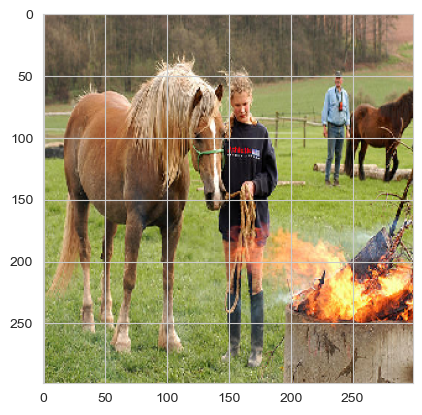

In [87]:
image_path = r"D:\DL_capstoneproject\Images\10815824_2997e03d76.jpg"

img = load_img(image_path, target_size=(299,299))
plt.imshow(img)

In [89]:
extimg = extract_image_features(inception_v3_model,image_path)
feature = extimg.flatten()
feature

array([0.34266344, 0.16739711, 0.09924426, ..., 0.2121681 , 0.46709558,
       0.2527647 ], dtype=float32)

In [91]:
greedy_generator(feature)

' a jockey and a woman are riding a horse'

# Computing the blue score for greedy search .................................................................

In [188]:
from nltk.translate.bleu_score import corpus_bleu

def BLEU_score_greedy(actual, greedy):
    # BLEU-1 and BLEU-4 for greedy search
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(1.0, 0, 0, 0))  # BLEU-1 (unigram)
    score_greedy_4 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU-4 (up to 4-gram)

    return [
        f'BLEU-1 (Greedy): {round(score_greedy_1, 5)}',
        f'BLEU-4 (Greedy): {round(score_greedy_4, 5)}',
        f'Example Prediction: {greedy[0]}',
        f'Ground Truth Reference: {actual[0]}'
    ]

# Generating captions for test image features ................................................................

In [277]:
generated_captions = {}

for image_id in tqdm(test_image_features):
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap

100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [01:23<00:00,  1.46it/s]


In [287]:
test_image_features

{'1042590306_95dea0916c.jpg': array([0.8822069 , 0.8236488 , 0.9581161 , ..., 0.20275827, 0.08772731,
        0.23736683], dtype=float32),
 '105342180_4d4a40b47f.jpg': array([0.14861652, 0.28157765, 0.24726927, ..., 0.6143398 , 0.54458225,
        0.1023398 ], dtype=float32),
 '1094462889_f9966dafa6.jpg': array([0.31549755, 0.24316058, 0.30439964, ..., 0.7859131 , 0.747674  ,
        0.49403208], dtype=float32),
 '1112212364_0c48235fc2.jpg': array([0.282665  , 0.46196416, 0.25073454, ..., 0.7038858 , 0.5388068 ,
        0.7126007 ], dtype=float32),
 '1129704496_4a61441f2c.jpg': array([0.0549477 , 0.11834921, 0.278057  , ..., 0.20119706, 0.9031715 ,
        0.42892885], dtype=float32),
 '1141718391_24164bf1b1.jpg': array([0.36912036, 0.03666219, 0.36332995, ..., 0.37848288, 0.00472548,
        0.14797828], dtype=float32),
 '143688283_a96ded20f1.jpg': array([0.78847796, 0.10806783, 0.28507668, ..., 0.8993194 , 0.9088291 ,
        0.09849803], dtype=float32),
 '1445754124_647168f211.jpg':

In [279]:
generated_captions

{'1042590306_95dea0916c.jpg': ' a group of adults and a woman are holding a picture',
 '105342180_4d4a40b47f.jpg': ' a man in a yellow kayak is riding a boat',
 '1094462889_f9966dafa6.jpg': ' a golden retriever is running through the snow',
 '1112212364_0c48235fc2.jpg': ' a young boy in a blue shirt and a hat and a baby sitting on a beach',
 '1129704496_4a61441f2c.jpg': ' a brown dog is playing in the water',
 '1141718391_24164bf1b1.jpg': ' a man in a green shirt is walking down a bridge',
 '143688283_a96ded20f1.jpg': ' a man in a white shirt is standing on a rock',
 '1445754124_647168f211.jpg': ' a dog jumps over a tree',
 '145721498_a27d2db576.jpg': ' a man in a blue wetsuit is riding a wave',
 '1457762320_7fe121b285.jpg': ' a man in a red shirt is riding a bicycle on a bicycle',
 '1468962616_5803b4397f.jpg': ' a girl in a blue suit is swimming underwater',
 '148512773_bae6901fd6.jpg': ' a man sits on a rocky path',
 '1490670858_e122df2560.jpg': ' a woman in a red shirt is sitting on

# Image Caption for the First Image

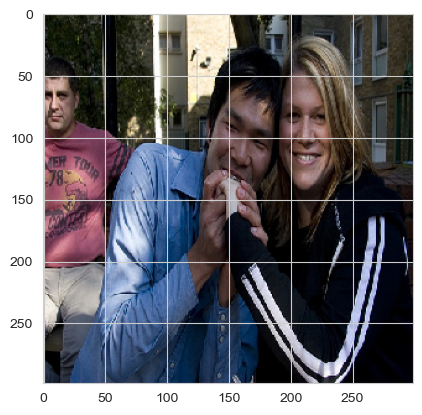

In [327]:
image_path = r"D:\DL_capstoneproject\Images\1042590306_95dea0916c.jpg"

img = load_img(image_path, target_size=(299,299))
plt.imshow(img)

In [329]:
extimg = extract_image_features(inception_v3_model,image_path)
feature = extimg.flatten()

In [331]:
greedy_generator(feature)

' a group of adults and a woman are holding a picture'

# Image Caption for the Second Image

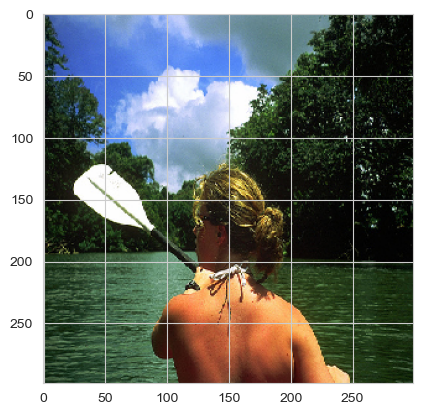

In [333]:
image_path = r"D:\DL_capstoneproject\Images\105342180_4d4a40b47f.jpg"

img = load_img(image_path, target_size=(299,299))
plt.imshow(img)

In [335]:
extimg = extract_image_features(inception_v3_model,image_path)
feature = extimg.flatten()

In [337]:
greedy_generator(feature)

' a man in a yellow kayak is riding a boat'

# Image Caption for the Third Image

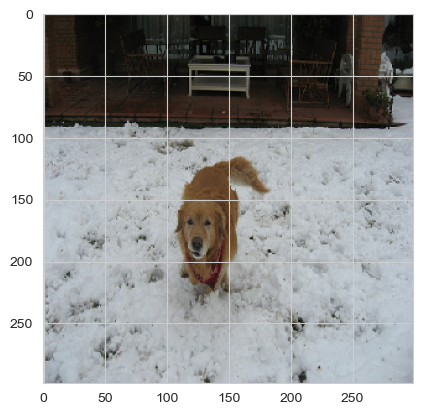

In [339]:
image_path = r"D:\DL_capstoneproject\Images\1094462889_f9966dafa6.jpg"

img = load_img(image_path, target_size=(299,299))
plt.imshow(img)

In [341]:
extimg = extract_image_features(inception_v3_model,image_path)
feature = extimg.flatten()

In [349]:
text = greedy_generator(feature)
print(text)

 a golden retriever is running through the snow


# Text Translation...................................................................................................................

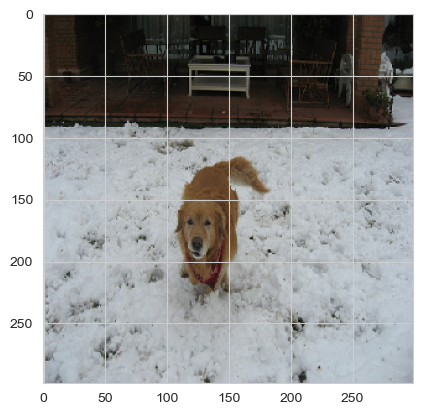

In [351]:
image_path = r"D:\DL_capstoneproject\Images\1094462889_f9966dafa6.jpg"

img = load_img(image_path, target_size=(299,299))
plt.imshow(img)

In [353]:
extimg = extract_image_features(inception_v3_model,image_path)
feature = extimg.flatten()

In [355]:
text = greedy_generator(feature)
print(text)

 a golden retriever is running through the snow


In [357]:
from googletrans import Translator

In [359]:
translator = Translator()
translated = translator.translate(caption, dest='fr')  # 'hi' for Hindi, 'fr' for french
print("Translated:", translated.text)

# Audio Translation.............................................................................................................

In [363]:
from gtts import gTTS

In [365]:
tts = gTTS(text, lang='en') 
tts.save("caption_audio.mp3")

In [366]:
from IPython.display import Audio
Audio("caption_audio.mp3")